In [1]:
!pip install pyswarms
!pip install -U albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [2]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pyswarms as ps
import joblib
import time
import albumentations as A

In [3]:
base_dir = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed"
categories = ["im_Dyskeratotic", "im_Koilocytotic", "im_Metaplastic", 
              "im_Parabasal", "im_Superficial-Intermediate"]
INPUT_SHAPE = 224

In [4]:
def display_images_from_folders(base_dir, categories, num_images=5):
    plt.figure(figsize=(15, 10))
    
    for i, category in enumerate(categories):
        category_path = os.path.join(base_dir, category,category,'CROPPED')
        image_files = [f for f in os.listdir(category_path) if f.endswith(('.bmp'))]
        
        for j, image_file in enumerate(image_files[:num_images]):
    
            img_path = os.path.join(category_path, image_file)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            
            plt.subplot(len(categories), num_images, i * num_images + j + 1)
            plt.imshow(image)
            plt.axis('off')  
            plt.title(f"{category}") 

    plt.tight_layout()
    plt.show()

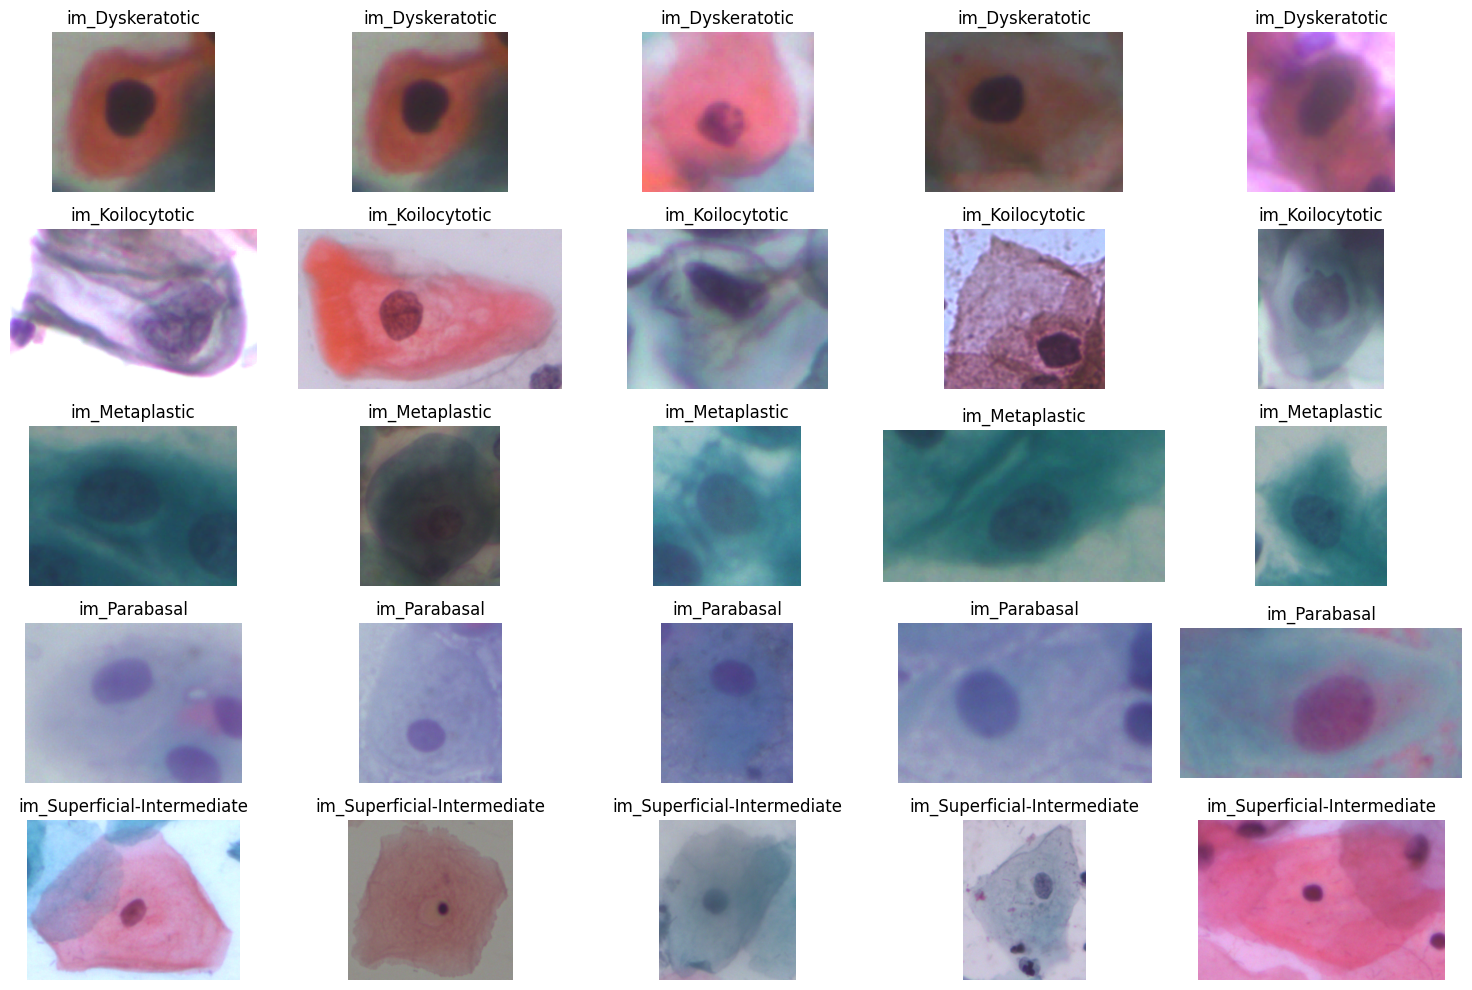

In [5]:
display_images_from_folders(base_dir, categories, num_images=5)

In [6]:
import os
import pandas as pd
import numpy as np

base_dir = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed"

# Define mapping of categories to classification and cell type
category_mapping = {
    "im_Dyskeratotic": ("Abnormal", "Dyskeratotic"),
    "im_Koilocytotic": ("Abnormal", "Koilocytotic"),
    "im_Metaplastic": ("Benign", "Metaplastic"),
    "im_Parabasal": ("Normal", "Parabasal"),
    "im_Superficial-Intermediate": ("Normal", "Superficial-Intermediate"),
}

# Collect image counts
data = []
for folder, (classification, cell_type) in category_mapping.items():
    folder_path = os.path.join(base_dir, folder, folder, "CROPPED")
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.bmp')]
    data.append((classification, cell_type, len(image_files)))

# Convert to MultiIndex DataFrame
index = pd.MultiIndex.from_tuples([(cls, cell) for cls, cell, _ in data], names=["Classification", "Cell Type"])
image_counts = np.array([count for _, _, count in data])

df = pd.DataFrame(image_counts, index=index, columns=["No. of Images"])

# Display the table
display(df)

No. of Images
Classification Cell Type                              
Abnormal       Dyskeratotic                        813
               Koilocytotic                        825
Benign         Metaplastic                         793
Normal         Parabasal                           787
               Superficial-Intermediate            831

In [7]:
# Data Loading Function
def load_dataset(dataset_path):
    """
    Traverses the dataset directory structure and loads only .bmp images.
    Expected structure:
      dataset_path/
         Dyskeratotic/Dyskeratotic/CROPPED/*.bmp
         Koilocytotic/Koilocytotic/CROPPED/*.bmp
         Metaplastic/Metaplastic/CROPPED/*.bmp
         Parabasal/Parabasal/CROPPED/*.bmp
         Superficial-Intermediate/Superficial-Intermediate/CROPPED/*.bmp
    """
    classes = ["im_Dyskeratotic", "im_Koilocytotic", "im_Metaplastic", "im_Parabasal", "im_Superficial-Intermediate"]
    images = []
    labels = []
    for cls in classes:
        folder_path = os.path.join(dataset_path, cls, cls, "CROPPED")
        file_list = glob.glob(os.path.join(folder_path, "*.bmp"))
        print(f"Found {len(file_list)} images in {folder_path}")
        for file in file_list:
            img = cv2.imread(file)
            if img is None:
                continue
            # Convert from BGR to RGB for consistency
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(cls)
    return images, labels

In [8]:
def get_augmentation_pipeline():
    return A.Compose([
        A.RandomRotate90(p=0.5),  # Random rotation by 90 degrees
        A.HorizontalFlip(p=0.5),  # Horizontal flip
        A.RandomBrightnessContrast(p=0.2),  # Random brightness and contrast change
        A.RandomCrop(height=100, width=100, p=0.5),  # Randomly crop a 100x100 region
        A.Resize(height=224, width=224, p=1.0),  # Resize to 224x224
        A.HueSaturationValue(p=0.3),  # Random hue, saturation, and value changes
        A.GaussianBlur(p=0.2),  # Apply Gaussian blur
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1.0),  # Normalize to ImageNet standards
    ])

In [9]:
# Image Preprocessing Function
def preprocess_images(images, target_size=(224, 224), augmentation_pipeline=None):
    proc_imgs = []
    for img in images:
        # Resize image to target size
        img_resized = cv2.resize(img, target_size)
        img_array = img_to_array(img_resized)
        img_array = augmentation_pipeline(image=img_array)["image"]
        proc_imgs.append(img_array)
    return np.array(proc_imgs)

In [10]:
# 3. Feature Extraction using a pre-trained model (EfficientNetB0 or MobileNet)
def extract_features(images):
    # Use EfficientNetB0 with global average pooling
    base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=(INPUT_SHAPE,INPUT_SHAPE,3))
    preproc_fn = tf.keras.applications.efficientnet.preprocess_input
    
    # Preprocess images as required by the model
    images_preprocessed = preproc_fn(images)
    
    # Extract features
    features = base_model.predict(images_preprocessed, verbose=1)
    return features

In [11]:
# 4. PSO Objective Function for Feature Selection
def objective_function(mask, X, y):
    """
    For each particle, select features based on the binary mask and evaluate the performance
    of an SVM classifier. The objective is to minimize (1 - accuracy).
    """
    n_particles = mask.shape[0]
    scores = np.zeros(n_particles)
    for i in range(n_particles):
        binary_mask = mask[i].astype(bool)
        # If no feature is selected, assign worst cost (1.0)
        if np.sum(binary_mask) == 0:
            scores[i] = 1.0
        else:
            # Select features based on mask
            X_selected = X[:, binary_mask]
            # Use a fixed random state for reproducibility
            X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.3, random_state=42)
            clf = SVC(kernel='linear', random_state=42)
            clf.fit(X_train, y_train)
            acc = clf.score(X_val, y_val)
            scores[i] = 1 - acc  # lower is better
    return scores

In [12]:
# Specify the dataset root directory (update this path as needed)
dataset_path = '/kaggle/input/cervical-cancer-largest-dataset-sipakmed'  # e.g., './SIPaKMeD'

In [13]:
# Load dataset
images, labels = load_dataset(dataset_path)
print(f"Total images loaded: {len(images)}")

Found 813 images in /kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Dyskeratotic/im_Dyskeratotic/CROPPED
Found 825 images in /kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Koilocytotic/im_Koilocytotic/CROPPED
Found 793 images in /kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Metaplastic/im_Metaplastic/CROPPED
Found 787 images in /kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/CROPPED
Found 831 images in /kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED
Total images loaded: 4049


In [14]:
augmentation_pipeline = get_augmentation_pipeline()  # Get the augmentation pipeline

# Preprocess images (resize to 224x224)
images_proc = preprocess_images(images, target_size=(224, 224),augmentation_pipeline=augmentation_pipeline)

In [15]:
# Extract features using EfficientNetB0
features = extract_features(images_proc)
print(f"Extracted features shape: {features.shape}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step
Extracted features shape: (4049, 1280)


In [16]:
np.save('features_EfficientNet.npy',features)

In [17]:
# Convert labels to a numpy array
y = np.array(labels)
X = features  # feature matrix

In [18]:
# PSO hyperparameters
options = {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 3, 'p': 2}
dimensions = X.shape[1]  # total number of features extracted

# Use BinaryPSO (for binary selection: 1=select feature, 0=discard)
optimizer = ps.discrete.BinaryPSO(n_particles=30, dimensions=dimensions, options=options)

In [19]:
# Start time tracking
start_time = time.time()

# Run PSO: note that the objective_function receives X and y via additional arguments
best_cost, best_pos = optimizer.optimize(objective_function, iters=50, X=X, y=y, verbose=True)
print("Best PSO cost (1 - best accuracy):", best_cost)
print("Number of selected features:", np.sum(best_pos))

# Calculate elapsed time
elapsed_time = time.time() - start_time

# Print the total time taken
print(f"Total time taken: {elapsed_time:.2f} seconds")

2025-03-13 04:31:05,527 - pyswarms.discrete.binary - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 3, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|50/50, best_cost=0.812
2025-03-13 06:31:49,070 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.8123456790123457, best pos: [1 1 1 ... 1 0 1]


Best PSO cost (1 - best accuracy): 0.8123456790123457
Number of selected features: 664
Total time taken: 7243.55 seconds


In [20]:
np.save('pso_efficientnet.npy',best_pos)

In [21]:
selected_features = best_pos.astype(bool)
X_selected = X[:, selected_features]

In [22]:
# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

In [23]:
# Train SVM classifier
clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [24]:
# Evaluate classifier
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.00      0.00      0.00       262
            im_Koilocytotic       0.00      0.00      0.00       254
             im_Metaplastic       0.00      0.00      0.00       251
               im_Parabasal       0.00      0.00      0.00       220
im_Superficial-Intermediate       0.19      1.00      0.32       228

                   accuracy                           0.19      1215
                  macro avg       0.04      0.20      0.06      1215
               weighted avg       0.04      0.19      0.06      1215



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# Save the model
joblib.dump(clf, "svm_linear_Eff_model.pkl")

['svm_linear_Eff_model.pkl']

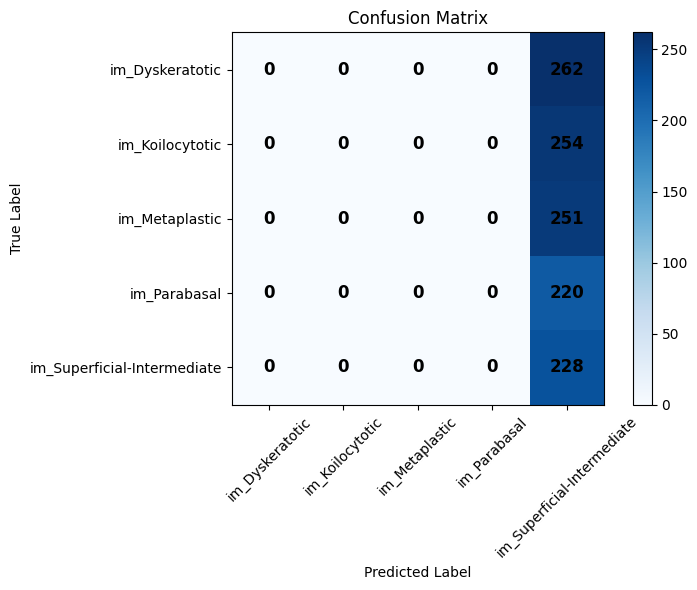

In [26]:
# Visualization: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y), rotation=45)
plt.yticks(tick_marks, np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Annotate cells with values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

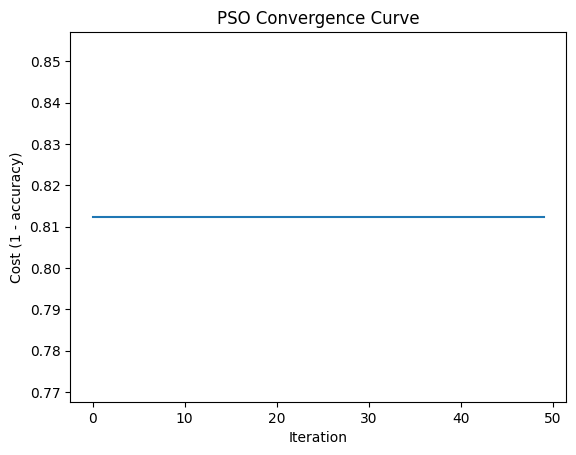

In [27]:
# Visualization: PSO Convergence Curve
plt.figure()
plt.plot(optimizer.cost_history)
plt.title("PSO Convergence Curve")
plt.xlabel("Iteration")
plt.ylabel("Cost (1 - accuracy)")
plt.show()